# ExpDesPy — Tutorial Completo

_Gerado em 2025-08-15 02:14_

> **Objetivo**: este notebook apresenta um passo‑a‑passo para usar o pacote **expdespy** em delineamentos clássicos (DIC, DBC, DQL), fatoriais, parcelas subdivididas (split‑plot), regressão polinomial para tratamentos quantitativos, diagnósticos e utilidades diversas.


## Sumário
1. [Instalação e importações](#instalacao)
2. [Datasets de exemplo](#datasets)
3. [Delineamentos clássicos](#classicos)
   - [DIC](#dic)
   - [DBC](#dbc)
   - [DQL](#dql)
4. [Delineamentos fatoriais](#fatoriais)
   - [ANOVA e desdobramentos de interação](#fatoriais-anova)
5. [Parcelas subdivididas (Split-Plot)](#splitplot)
6. [Regressão polinomial (tratamentos quantitativos)](#regressao)
   - [Ajuste, ANOVA, diagnóstico e gráficos](#regressao-detalhes)
7. [Pós-testes (Tukey, t-test) e letras compactas](#posthoc)
8. [Utilidades: get_summary e assign_letters](#utils)



<a id='instalacao'></a>

## 1) Instalação e importações

Se ainda não instalou o pacote:

```bash
pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple expdespy
```

Depois, carregue os módulos principais:


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelos (clássicos, fatoriais e parcelas)
from expdespy.models import CRD, RCBD, LSD
from expdespy.models.fatorial_dic import FactorialCRD
from expdespy.models.fatorial_dbc import FactorialRCBD
from expdespy.models.splitplot_dic import SplitPlotCRD
from expdespy.models.splitplot_dbc import SplitPlotRCBD

# Regressão
from expdespy.regressao.polynomial import PolynomialRegression
from expdespy.regressao import diagnostics as reg_diag

# Pós-testes utilitários
from expdespy.posthoc import PostHocLoader

# Datasets
from expdespy.datasets.dbc_caprinos import load_dbc_caprinos
from expdespy.datasets.dic_milho import load_dic_milho
from expdespy.datasets.dql_cana import load_dql_cana
from expdespy.datasets.fatorial_dic_irrigacao import load_fatorial_dic
from expdespy.datasets.fatorial_dic_nitrogenio_fosforo import load_fatorial_dic_nitrogenio_fosforo
from expdespy.datasets.fatorial_dbc_np import load_fatorial_rcbd_np
from expdespy.datasets.splitplot_dataset import load_splitplot_dic, load_splitplot_dbc

# Utils
from expdespy.utils.utils import get_summary, assign_letters

np.random.seed(123)  # reprodutibilidade dos exemplos


<a id='datasets'></a>

## 2) Datasets de exemplo

O pacote inclui alguns datasets sintéticos para demonstração.


In [ ]:
df_dbc, meta_dbc = load_dbc_caprinos()
df_dic, meta_dic = load_dic_milho()
df_dql, meta_dql = load_dql_cana()
df_fat_dic, meta_fat_dic = load_fatorial_dic()
df_fat_dic_nf, meta_fat_dic_nf = load_fatorial_dic_nitrogenio_fosforo()
df_fat_dbc, meta_fat_dbc = load_fatorial_rcbd_np()
df_sp, meta_sp = load_splitplot_dic()

print("RCBD (caprinos) — colunas:", df_dbc.columns.tolist())
print("CRD (milho)    — colunas:", df_dic.columns.tolist())
print("LSD (cana)     — colunas:", df_dql.columns.tolist())
print("Fatorial CRD   — colunas:", df_fat_dic.columns.tolist())
print("Fatorial CRD NF— colunas:", df_fat_dic_nf.columns.tolist())
print("Fatorial RCBD   — colunas:", df_fat_dbc.columns.tolist())
print("Split-Plot     — colunas:", df_sp.columns.tolist())

df_dbc.head()

DBC (caprinos) — colunas: ['bloco', 'produto', 'ppm_micronutriente']
DIC (milho)    — colunas: ['variedade', 'produtividade']
DQL (cana)     — colunas: ['linha', 'coluna', 'tratamento', 'resposta']
Fatorial DIC   — colunas: ['f1', 'f2', 'produtividade']
Fatorial DIC NF— colunas: ['f1', 'f2', 'produtividade']
Fatorial DBC   — colunas: ['block', 'N', 'P', 'produtividade']
Split-Plot     — colunas: ['cultivar', 'adubo', 'produtividade']


,bloco,produto,ppm_micronutriente
0,1,1,83
1,1,2,86
2,1,3,103
3,1,4,116
4,1,5,132


<a id='classicos'></a>

## 3) Delineamentos clássicos

Nesta seção, rodamos **ANOVA** e verificações de pressupostos nos delineamentos clássicos.
Os métodos seguem a mesma interface: `anova()`, `check_assumptions()`. Há ainda métodos
de pós-teste via `PostHocLoader` quando pertinente.


<a id='dic'></a>

### 3.1) DIC — Delineamento Inteiramente Casualizado

In [34]:
df, meta = df_dic, meta_dic
response = meta['response']
trat = meta['trat']
print("Response:", response)
print("Treatment:", trat)
print("DataFrame Head:")
print(df.head())

Response: produtividade
Treatment: variedade
DataFrame Head:
  variedade  produtividade
0         A             25
1         A             26
2         A             20
3         A             23
4         A             21


In [ ]:
# Usando o dataset CRD de milho
model_dic = CRD(data=df, response=response, treatment=trat)
anova_dic = model_dic.anova()
assum_dic = model_dic.check_assumptions(print_conclusions=False)

print(anova_dic)

print(json.dumps(assum_dic, indent=2, ensure_ascii=False)) 

              sum_sq    df         F    PR(>F) Signif
C(variedade)  163.75   3.0  7.797619  0.001976     **
Residual      112.00  16.0       NaN       NaN       
{
  "normality (Shapiro-Wilk)": {
    "H0": "The residuals are normally distributed",
    "H1": "The residuals are not normally distributed",
    "p-value": 0.2358735765866306,
    "Conclusion": "H0 must not be rejected"
  },
  "homoscedasticity (Levene)": {
    "H0": "The variances of the groups are equal",
    "H1": "The variances of the groups are not equal",
    "p-value": 1.0,
    "Conclusion": "H0 must not be rejected"
  }
}


<a id='dbc'></a>

### 3.2) DBC — Delineamento em Blocos Casualizados

In [ ]:
df, meta = df_dbc, meta_dbc
response = meta['response']
treatment = meta['trat']
model_dbc = RCBD(data=df, response=response, treatment=treatment, block='bloco')
anova_dbc = model_dbc.anova()
assum_dbc = model_dbc.check_assumptions(print_conclusions=False)

print(anova_dbc)
print(json.dumps(assum_dbc, indent=2, ensure_ascii=False))

            sum_sq   df          F    PR(>F) Signif
C(produto)  3090.0  4.0  33.586957  0.000048    ***
C(bloco)    2770.0  2.0  60.217391  0.000015    ***
Residual     184.0  8.0        NaN       NaN       
{
  "normality (Shapiro-Wilk)": {
    "H0": "The residuals are normally distributed",
    "H1": "The residuals are not normally distributed",
    "p-value": 0.2591356395863862,
    "Conclusion": "H0 must not be rejected"
  },
  "homoscedasticity (Levene)": {
    "H0": "The variances of the groups are equal",
    "H1": "The variances of the groups are not equal",
    "p-value": NaN,
    "Conclusion": "H0 must be rejected"
  }
}


/Users/cristianooliveira/Documents/expdespy/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:3310: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


<a id='dql'></a>

### 3.3) DQL — Delineamento em Quadrado Latino

In [ ]:
df, meta = df_dql, meta_dql
response = meta['response']
treatment = meta['trat']
row = meta['rows']
cols = meta['cols']
model_dql = LSD(data=df, response=response, treatment=treatment, block_row=row, block_col=cols)
anova_dql = model_dql.anova()
assum_dql = model_dql.check_assumptions(print_conclusions=False)

print(anova_dql)
print(json.dumps(assum_dql, indent=2, ensure_ascii=False))


                  sum_sq    df          F    PR(>F) Signif
C(tratamento)  137488.24   4.0  12.090520  0.000358    ***
C(linha)        30480.64   4.0   2.680424  0.083134     ns
C(coluna)       55640.64   4.0   4.892959  0.014229      *
Residual        34114.72  12.0        NaN       NaN       
{
  "normality (Shapiro-Wilk)": {
    "H0": "The residuals are normally distributed",
    "H1": "The residuals are not normally distributed",
    "p-value": 0.8201574512719092,
    "Conclusion": "H0 must not be rejected"
  },
  "homoscedasticity (Levene)": {
    "H0": "The variances of the groups are equal",
    "H1": "The variances of the groups are not equal",
    "p-value": NaN,
    "Conclusion": "H0 must be rejected"
  }
}


/Users/cristianooliveira/Documents/expdespy/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:3310: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


<a id='fatoriais'></a>

## 4) Delineamentos fatoriais

Vamos analisar fatoriais tanto em DIC quanto DBC. A API permite rodar ANOVA com marcador de significância
e, quando há interação significativa, desdobrar as interações e aplicar pós-testes automaticamente.


<a id='fatoriais-anova'></a>

### 4.1) Fatorial em DIC

In [ ]:
df, meta = df_fat_dic, meta_fat_dic

fat_dic = FactorialCRD(data=df, response=meta['response'], factors=meta['factors'])
anova_fat_dic = fat_dic.run_anova()  # inclui coluna "Signif"
display(anova_fat_dic)

# Desdobramento condicional: aplica post hoc quando não há interação ou desdobra quando há
res_unfold_dic = fat_dic.unfold_interactions(alpha=0.05, print_results=False, posthoc="tukey")
res_unfold_dic.keys()

,sum_sq,df,F,PR(>F),Signif
C(f1),1200.0,1.0,88.888889,0.000013,***
C(f2),588.0,1.0,43.555556,0.000169,***
C(f1):C(f2),300.0,1.0,22.222222,0.001514,**
Residual,108.0,8.0,NaN,NaN,


dict_keys(['anova', 'main_effects', 'interactions'])

### 4.2) Fatorial em DBC

In [41]:
meta

{'description': '\n        Dados de um experimento fatorial 2×2 em delineamento em blocos completos (RCBD),\n        com 5 repetições por combinação de fatores.\n        Fatores:\n            N (fator A): 0 (baixo), 1 (alto)\n            P (fator B): 0 (baixo), 1 (alto)\n    ',
 'response': 'produtividade',
 'factors': ['N', 'P'],
 'blocks': 'block',
 'source': 'Exemplo fictício'}

In [ ]:
df, meta = df_fat_dbc, meta_fat_dbc

fat_dbc = FactorialRCBD(data=df, response=meta['response'], factors=meta['factors'], block='block')
anova_fat_dbc = fat_dbc.run_anova()
display(anova_fat_dbc)

res_unfold_dbc = fat_dbc.unfold_interactions(alpha=0.05, print_results=False, posthoc="tukey")
res_unfold_dbc.keys()

,sum_sq,df,F,PR(>F),Signif
C(N),16.3805,1.0,21.293656,0.000337,***
C(P),13.2845,1.0,17.269044,0.000845,***
C(N):C(P),3.6125,1.0,4.696031,0.046739,*
block,0.1210,1.0,0.157293,0.697247,ns
Residual,11.5390,15.0,NaN,NaN,


dict_keys(['anova', 'main_effects', 'interactions'])

<a id='splitplot'></a>

## 5) Parcelas subdivididas (Split‑Plot)

Exemplo de análise com parcela principal e subparcela. A API também provê `run_anova()` e `unfold_interactions()`.


In [ ]:
df, meta = df_sp, meta_sp

sp_dic = SplitPlotCRD(data=df, response=meta['response'],
                    main_plot=meta['main_plot'], subplot=meta['subplot'])
anova_sp = sp_dic.run_anova()
display(anova_sp)

res_sp = sp_dic.unfold_interactions(alpha=0.05, print_results=False, posthoc="tukey")
res_sp.keys()

,sum_sq,df,F,PR(>F),Signif
C(cultivar),11.842222,1.0,101.504762,3.303508e-07,***
C(adubo),41.204444,2.0,176.590476,1.259038e-09,***
C(cultivar):C(adubo),3.017778,2.0,12.933333,1.012850e-03,**
Residual,1.400000,12.0,NaN,NaN,


dict_keys(['anova', 'main_effects', 'interactions'])

<a id='regressao'></a>

## 6) Regressão polinomial (tratamentos quantitativos)

Para tratamentos quantitativos, usamos `PolynomialRegression`. A fórmula usa termos criados como `dose`, `dose^2`, etc.
Os diagnósticos ficam no módulo `expdespy.regressao.diagnostics`.


In [44]:
# Exemplo simples
df_reg = pd.DataFrame({
    "dose": [0, 1, 2, 3, 4, 5, 6],
    "yield": [3.0, 4.5, 6.5, 9.0, 12.2, 16.0, 21.0]
})

reg = PolynomialRegression(data=df_reg, response="yield", treatment="dose")
results = reg.fit(degree=2)  # quadrático
display(reg.anova())
results.summary()

,df,sum_sq,mean_sq,F,PR(>F)
Q('dose'),1.0,244.260357,244.260357,8046.223529,9.259922e-08
Q('dose^2'),1.0,9.266786,9.266786,305.258824,6.300705e-05
Residual,4.0,0.121429,0.030357,NaN,NaN


/Users/cristianooliveira/Documents/expdespy/.venv/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Q('yield')   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4176.
Date:                Fri, 15 Aug 2025   Prob (F-statistic):           2.29e-07
Time:                        17:02:55   Log-Likelihood:                 4.2576
No. Observations:                   7   AIC:                            -2.515
Df Residuals:                       4   BIC:                            -2.678
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.1143      0.152     20.478      0.000       2.692       3.537
Q('dose')       0.9607      0.119      8.092      0.001       0.631       1.290
Q('dose^2')     0.3321      0.019     17.472      0.000       0.279       0.385
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.961
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.549
Skew:                          -0.311   Prob(JB):                        0.760
Kurtosis:                       1.777   Cond. No.                         51.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

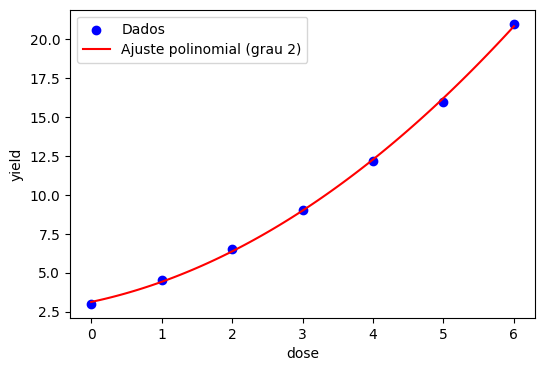

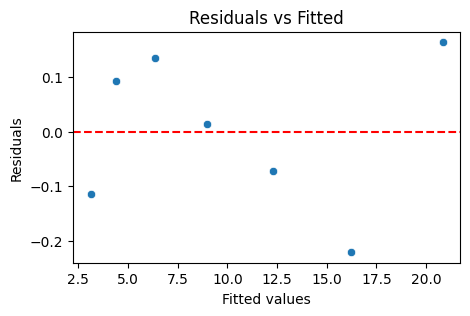

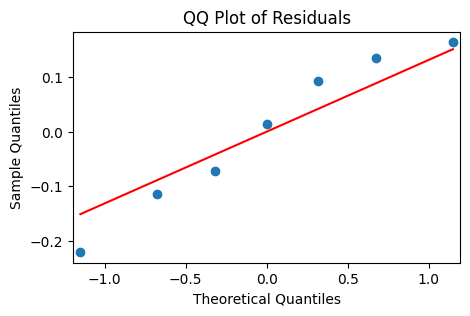

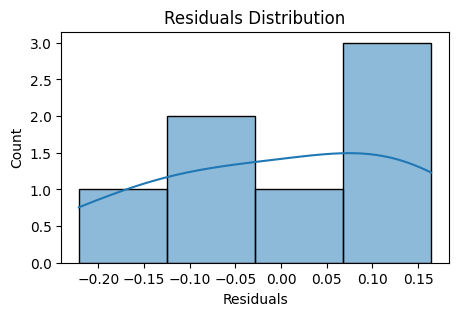

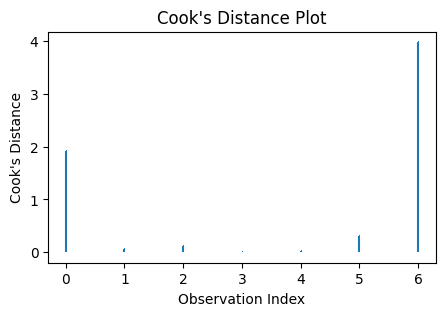

{'shapiro': {'statistic': 0.9479803470716716, 'p_value': 0.7112847126691357},
 'breusch_pagan': {'lm_stat': 2.670656510700221,
  'lm_pvalue': 0.26307180655331264,
  'f_stat': 1.2337466487937037,
  'f_pvalue': 0.382514592823314},
 'durbin_watson': 1.9609243697479002}

In [45]:
# Plot do ajuste usando o padrão "ax" do projeto
fig, ax = plt.subplots(figsize=(6,4))
reg.plot(ax=ax)
plt.show()

# Diagnósticos (cada função aceita 'ax' e retorna o mesmo Axes)
fig, ax = plt.subplots(figsize=(5,3))
reg_diag.plot_residuals_vs_fitted(results, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,3))
reg_diag.qq_plot_residuals(results, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,3))
reg_diag.plot_residual_hist(results, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,3))
reg_diag.cooks_distance_plot(results, ax=ax)
plt.show()

# Testes numéricos
{
    "shapiro": reg_diag.shapiro_test(results),
    "breusch_pagan": reg_diag.breusch_pagan_test(results),
    "durbin_watson": reg_diag.durbin_watson_test(results)
}

<a id='posthoc'></a>

## 7) Pós-testes (Tukey, t-test) e letras compactas

Os pós-testes são acessíveis via `PostHocLoader.create(...)`. Exemplo com Tukey:


In [ ]:
# Exemplo: aplicar Tukey no dataset CRD (tratamentos categóricos)
df, meta = df_dic, meta_dic

tukey = PostHocLoader.create(
    test_name="tukey",
    data=df,
    values_column=meta['response'],
    treatments_column=meta['trat'],
    alpha=0.05
)

letters = tukey.run_compact_letters_display()
letters

,variedade,Mean,Letters
3,D,31.0,a
1,B,27.0,ab
2,C,26.0,b
0,A,23.0,b


<a id='utils'></a>

## 8) Utilidades: `get_summary` e `assign_letters`

- `get_summary(df)`: sumariza colunas (tipo, NA, top class, etc.).  
- `assign_letters(...)`: constrói **Compact Letter Display** a partir de uma tabela de comparações pós‑hoc.


In [49]:
# get_summary
summary = get_summary(df_dic)
summary

# Exemplo mínimo de assign_letters (dados fictícios de pós-hoc)
df_ph = pd.DataFrame({
    "A": ["T1", "T1", "T2"],
    "B": ["T2", "T3", "T3"],
    "p": [0.08, 0.20, 0.03],  # T1 vs T2 (ns), T1 vs T3 (ns), T2 vs T3 (sig)
})
assign_letters(df_ph, G1="A", G2="B", P="p")

,Letters
Group,
T1,ab
T2,a
T3,b
